<a href="https://colab.research.google.com/github/Vijay-K-2003/Deep_Learning_Models/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Networks (DCGANs) with PyTorch Lightning

Research Paper: [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434)

Architecture guidelines for stable Deep Convolutional GANs
- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

### Training Process
The training involves alternating updates for the Generator and Discriminator:
- For the Generator:
  - Generate fake samples from random noise.
  - Calculate the loss based on how well the Discriminator classifies these samples as real.
  - Update the Generator's parameters to minimize this loss.

- For the Discriminator:
  - Evaluate real data to calculate the loss for correctly identifying it as real.
  - Evaluate fake data to calculate the loss for correctly identifying it as fake.
  - Update the Discriminator's parameters to minimize the combined loss.

This alternating process ensures that both networks improve iteratively.


In [12]:
!pip install lightning

In [13]:
import lightning as L

import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split

from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

import os

In [14]:
random_seed = 42
torch.manual_seed(random_seed)

In [15]:
BATCH_SIZE = 128
NUM_WORKERS = int(os.cpu_count()/2)
AVAILABLE_GPUS = torch.cuda.device_count()
GEN_FEATURES = 64
DISC_FEATURES = 64
NUM_CHANNELS = 1
IMG_SIZE = 64
LATENT_DIM = 100
EPOCHS = 15
LR = 0.0002
BETA = 0.5

In [16]:
class MNISTDataModule(L.LightningDataModule):

    def __init__(self,
                 data_dir="./data",
                 batch_size=BATCH_SIZE,
                 num_workers=NUM_WORKERS,
                 image_size=IMG_SIZE) -> None:
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            transforms.Normalize((0.5,), (0.5,))
        ])

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: str) -> None:
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # self.conv2_drop = nn.Dropout2d()
        # self.fc1 = nn.Linear(320, 50)
        # self.fc2 = nn.Linear(50, 1)

        self.model = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(NUM_CHANNELS, DISC_FEATURES, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(DISC_FEATURES, DISC_FEATURES * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DISC_FEATURES * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(DISC_FEATURES * 2, DISC_FEATURES * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DISC_FEATURES * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(DISC_FEATURES * 4, DISC_FEATURES * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DISC_FEATURES * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(DISC_FEATURES * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
        # x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # x = x.view(-1, 320)
        # x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        # x = self.fc2(x)

        # return torch.sigmoid(x)

In [18]:
class Generator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        # self.lin1 = nn.Linear(latent_dim, 7*7*64)
        # self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)
        # self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)
        # self.conv = nn.Conv2d(16, 1, kernel_size=7)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, GEN_FEATURES * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(GEN_FEATURES * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(GEN_FEATURES * 8, GEN_FEATURES * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FEATURES * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( GEN_FEATURES * 4, GEN_FEATURES * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FEATURES * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( GEN_FEATURES * 2, GEN_FEATURES, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FEATURES),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( GEN_FEATURES, NUM_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        # Latent Space to Linear Layer and Reshape
        return self.model(x)

In [19]:
class GAN(L.LightningModule):
    def __init__(self,
                 latent_dim=LATENT_DIM,
                 lr=LR):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        # Random Noise to test the images.
        self.validation_z = torch.randn(6, self.hparams.latent_dim)

        self.g_losses = []
        self.d_losses = []

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1) #newline
        return self.generator(z)

    def adversarial_loss(self, predicted_labels, actual_labels):
        predicted_labels = predicted_labels.view_as(actual_labels)
        return F.binary_cross_entropy(predicted_labels, actual_labels)

    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.view(z.size(0), z.size(1), 1, 1) # newline
        z = z.type_as(real_imgs)
        # self.print("here")
        opt_g, opt_d = self.optimizers()

        opt_g.zero_grad()
        # self.print("here")
            # Generator: Maximize log(D(G(z)))
        fake_imgs = self(z)
        # self.print("here")
        predicted_labels = self.discriminator(fake_imgs)
        # self.print("here")
        actual_labels = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
        g_loss = self.adversarial_loss(predicted_labels, actual_labels)
        # self.print("here")
        self.log("g_loss", g_loss, prog_bar=True)
        self.manual_backward(g_loss)
        self.g_losses.append(g_loss.item())
        opt_g.step()

        opt_d.zero_grad()
        # Discriminator : Maximize log(D(x)) + log(1-D(G(x)))
        # How well can the Discriminator label as real
        real_predicted_labels = self.discriminator(real_imgs)
        actual_labels = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
        d_loss_real = self.adversarial_loss(real_predicted_labels, actual_labels)
        # How well can the Discriminator label as fake
        fake_imgs = self(z).detach()
        fake_predicted_labels = self.discriminator(fake_imgs)
        actual_labels = torch.zeros(real_imgs.size(0), 1).type_as(real_imgs)

        d_loss_fake = self.adversarial_loss(fake_predicted_labels, actual_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2
        self.log("d_loss", d_loss, prog_bar=True)
        self.manual_backward(d_loss)
        self.d_losses.append(d_loss.item())
        opt_d.step()


    def configure_optimizers(self):
        lr = self.hparams.lr

        opt_g = optim.Adam(self.generator.parameters(), lr=lr, betas=(BETA, 0.999))
        opt_d = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(BETA, 0.999))

        return [opt_g, opt_d], []

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.g_losses, label="Generator Loss")
        plt.plot(self.d_losses, label="Discriminator Loss")
        plt.xlabel("Training Step")
        plt.ylabel("Loss")
        plt.title("GAN Training Losses")
        plt.legend()
        plt.show()

    # def plot_images(self):
    #     # Ensure validation_z is on the same device as the generator
    #     z = self.validation_z.to(self.device)

    #     # Generate images using the generator
    #     sample_imgs = self(z).detach().cpu()

    #     # Plot the generated images
    #     print(f"Epoch {self.current_epoch}")
    #     fig, axes = plt.subplots(2, 3, figsize=(10, 7))  # Create a 2x3 grid
    #     for i, ax in enumerate(axes.flatten()):
    #         ax.imshow(sample_imgs[i, 0, :, :], cmap="gray_r", interpolation="none")
    #         ax.set_title("Generated Data")
    #         ax.axis("off")  # Turn off axis for cleaner display
    #     plt.tight_layout()
    #     plt.show()

    def on_train_epoch_end(self):
        # self.plot_images()
        self.plot_losses()


In [20]:
dm = MNISTDataModule()
model = GAN()

In [21]:
# model.plot_images()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 3.6 M  | train
1 | discriminator | Discriminator | 2.8 M  | train
--------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.353    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.

Training: |          | 0/? [00:00<?, ?it/s]

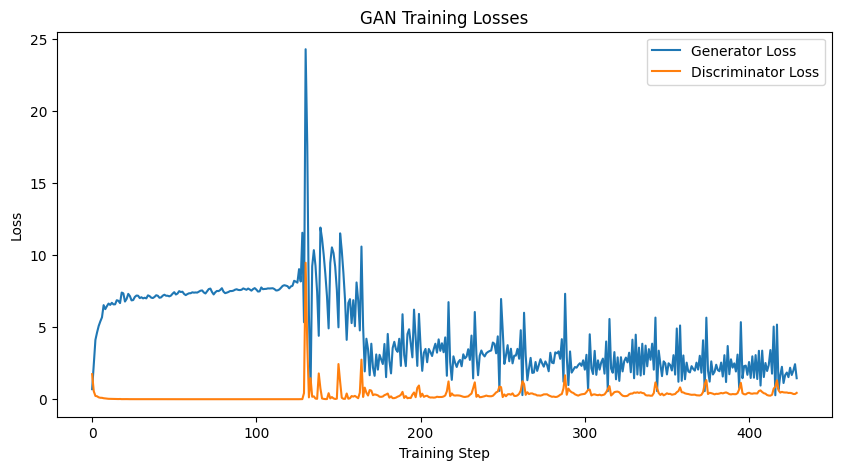

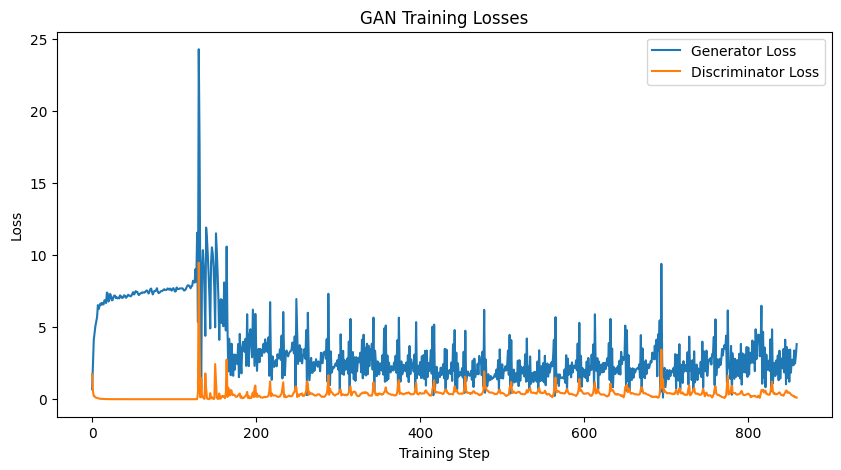

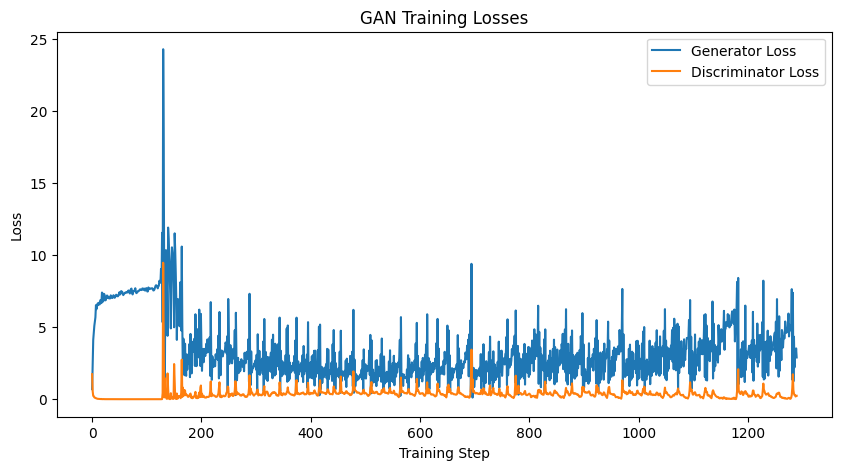

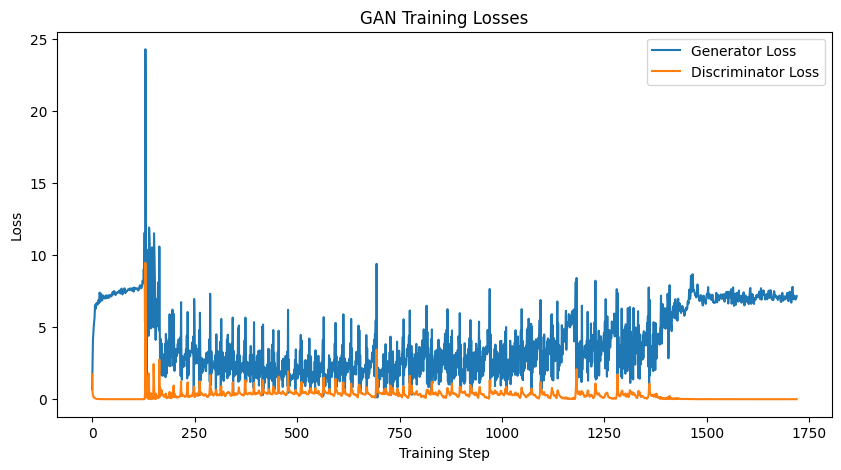

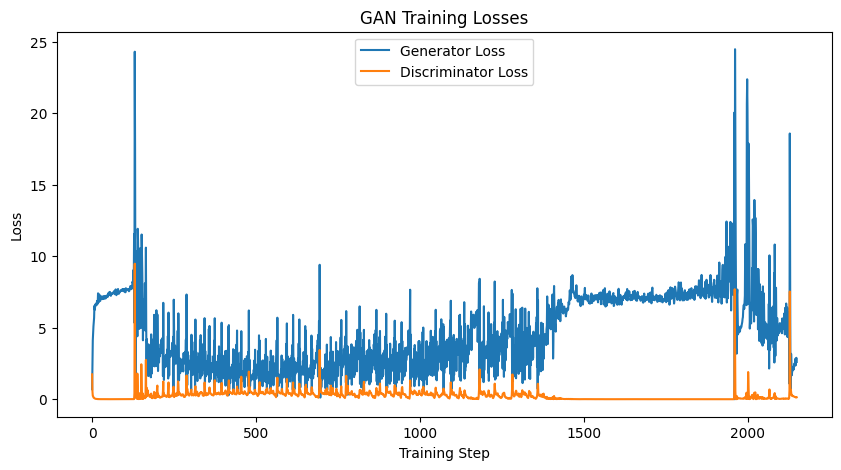

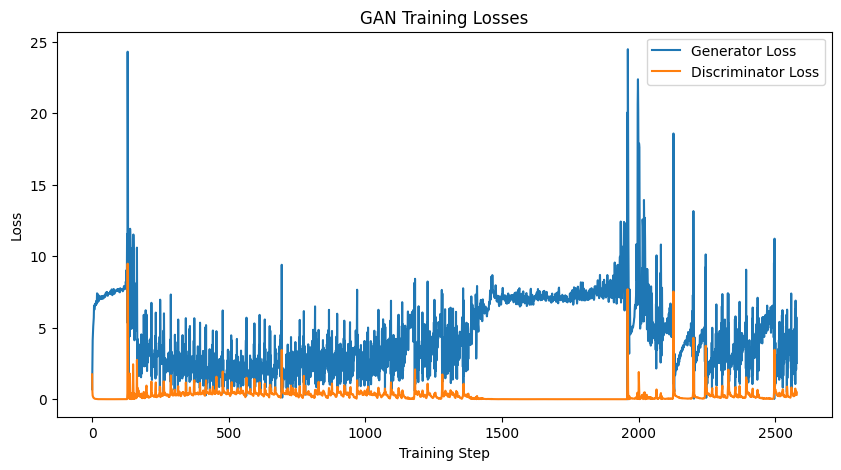

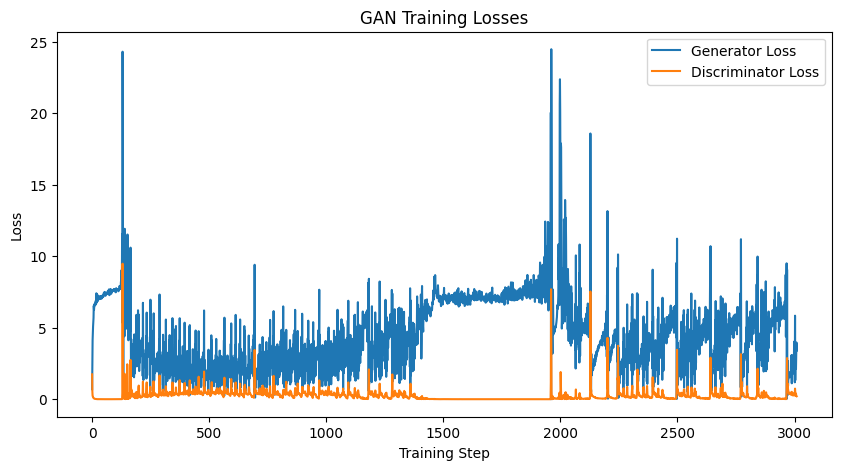

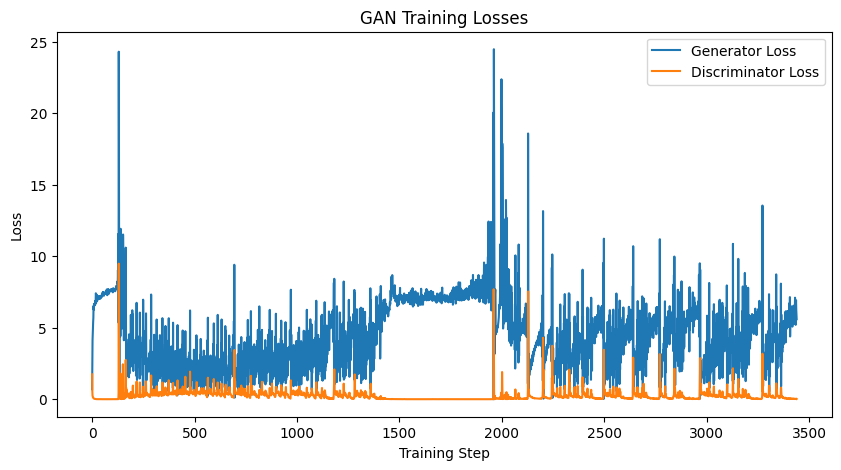

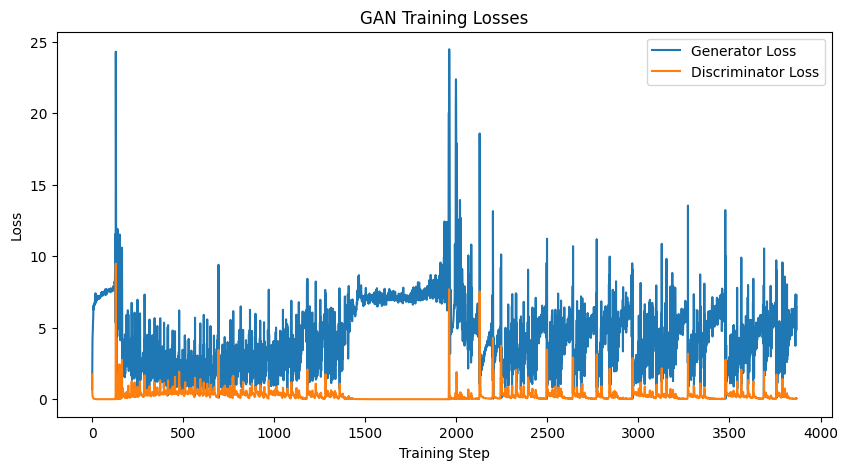

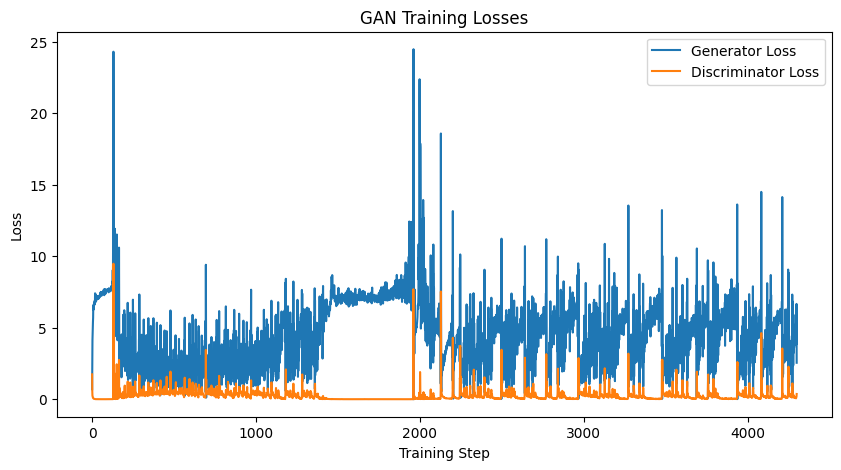

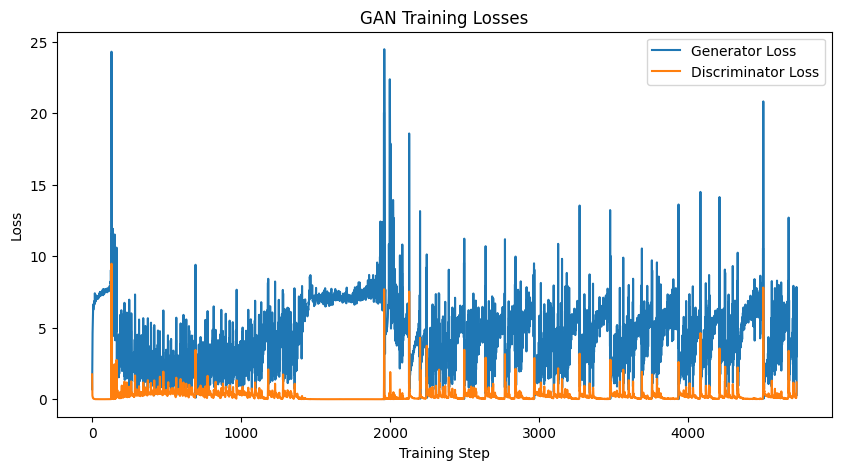

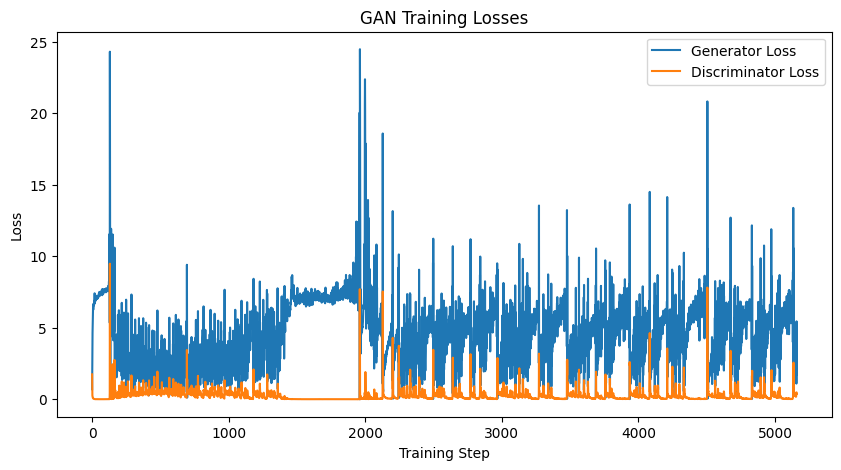

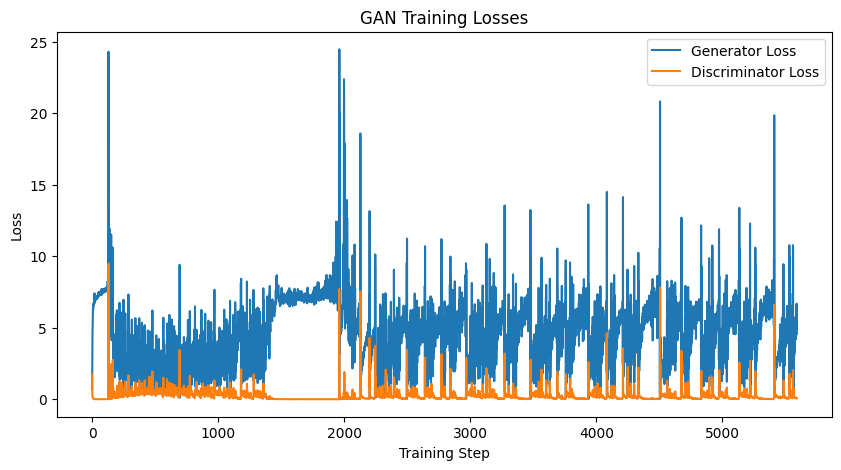

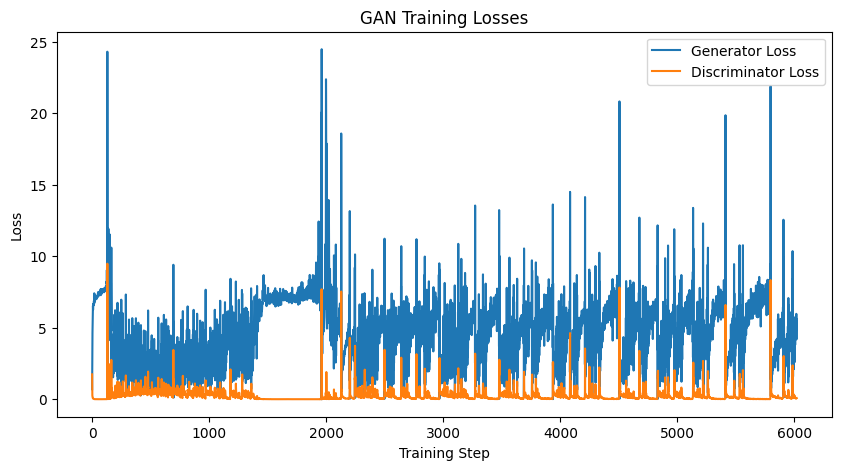

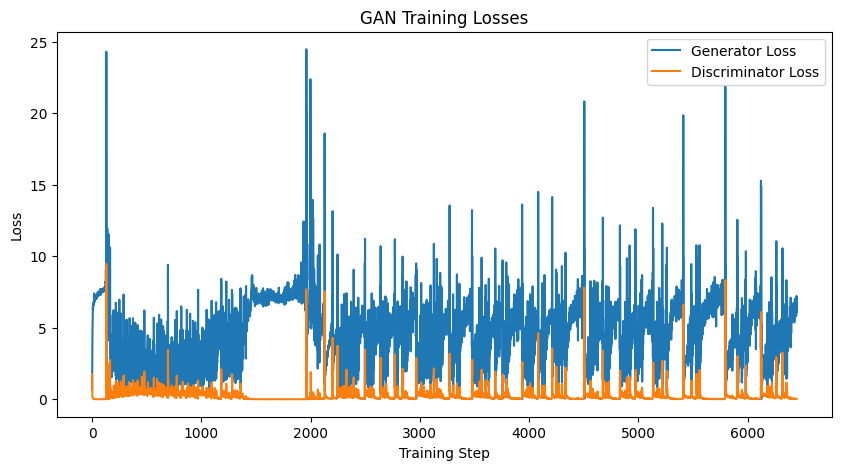

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [22]:
trainer = L.Trainer(max_epochs=EPOCHS, accelerator='gpu', devices=AVAILABLE_GPUS)
trainer.fit(model, dm)

In [23]:
# model.plot_images()

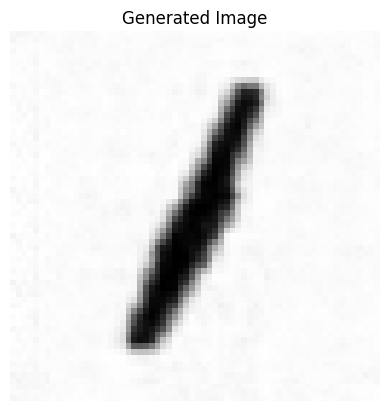

In [34]:
# Set the model to evaluation mode
model.eval()

# Generate a random latent vector z
latent_dim = model.hparams.latent_dim  # Assumes latent_dim is defined in the model's hyperparameters
z = torch.randn(1, latent_dim, 1, 1, device=model.device)  # Batch size 1

# Generate output using the generator
with torch.no_grad():  # No gradients needed for inference
    generated_img = model.generator(z).cpu()  # Move to CPU for visualization

# The generator output should have shape [1, NUM_CHANNELS, H, W], extract the first image
generated_img = generated_img.squeeze(0)  # Remove batch dimension

# If grayscale (1 channel), remove the channel dimension
if generated_img.shape[0] == 1:
    generated_img = generated_img.squeeze(0)

# Plot the generated image
plt.imshow(generated_img.numpy(), cmap="gray_r" if generated_img.ndim == 2 else None)
plt.title("Generated Image")
plt.axis("off")
plt.show()